In this repo, I will use Feature Engineer techniques, I have learned in Feature Engineering practices, to improve predictive power for House Prices problems

### Set up notebook environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

#set Matplotlib defaults
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc(
    "axes",
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=14,
    titlepad=10,)

In [32]:
pd.set_option('display.max_columns', 20) #showing all columns
pd.set_option("display.max_rows", 20) #show all rows

In [33]:
#loading description file
discription_file = "./house-prices-advanced-regression-techniques/data_description.txt"
with open(discription_file) as f:
    contents = f.read()
    print(contents)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

#### loading data

In [34]:
df_pretrain = pd.read_csv("./house-prices-advanced-regression-techniques/train.csv", index_col="Id")
df_pretest = pd.read_csv("./house-prices-advanced-regression-techniques/test.csv", index_col="Id")
df = pd.concat([df_pretrain, df_pretest])
print(df.shape)
df.head(5)

(2919, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


#### preprocessing data

In [35]:
#Examine the features
#the loop will go through each features and it's values
#enter space to keep go through each features, enter 'break' to exit
print(f"There are {df.shape[1]} columns")
for col in df.columns:
    enter = input()
    if enter == "break": #exit loop
        break
    else:
        print(f"{col} - {df[col].dtype}:", df[col].unique())

There are 80 columns
MSSubClass - int64: [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40 150]
MSZoning - object: ['RL' 'RM' 'C (all)' 'FV' 'RH' nan]


Investting every columns, we see there is typos in Exterior2nd mismatching with Exterior1st, and wrong assigned dtype - MSSubClass should be object not interger type, and those missing values (nan value) in some categorical columns, is actually absence, likes house with no basements, no pool, no garage, we will treat them right for better performance, for those in continous and discrete columns we need to impute

In [36]:
def cleaning_df(df): #function to clean our df
    df['Exterior2nd'] = df['Exterior2nd'].replace({"Brk Cmn" : "BrkComn"})
    #Some values of GarageYrBlt are corrupt, so we'll replace them with the year the house was built
    df['GarageYrBlt'] = df['GarageYrBlt'].where(df['GarageYrBlt'] <= 2010, df.YearBuilt)
    
    
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

In [37]:
# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encoding_df(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name] = df[name].cat.add_categories("None")
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels, ordered=True))
    return df

from pandas.api.types import CategoricalDtype
def imputing_df(df):
    #We'll impute 0 for missing numeric values and "None" for missing categorical values
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

In [38]:
def preprocessing_df(df, df_pretrain, df_pretest):
    df = cleaning_df(df)
    df = encoding_df(df)
    df = imputing_df(df)
    #if 'MSZoning' in df.columns.to_list():
        #df.drop(columns=['MSZoning'], inplace=True)
    # Reform splits
    df_train = df.loc[df_pretrain.index, :]
    df_test = df.loc[df_pretest.index, :]
    return df_train, df_test

In [39]:
#loading data
df_train, df_test = preprocessing_df(df, df_pretrain, df_pretest)

In [40]:
display(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1460 non-null   category
 1   MSZoning          1460 non-null   category
 2   LotFrontage       1460 non-null   float64 
 3   LotArea           1460 non-null   int64   
 4   Street            1460 non-null   category
 5   Alley             1460 non-null   category
 6   LotShape          1460 non-null   category
 7   LandContour       1460 non-null   category
 8   Utilities         1460 non-null   category
 9   LotConfig         1460 non-null   category
 10  LandSlope         1460 non-null   category
 11  Neighborhood      1460 non-null   category
 12  Condition1        1460 non-null   category
 13  Condition2        1460 non-null   category
 14  BldgType          1460 non-null   category
 15  HouseStyle        1460 non-null   category
 16  OverallQual       1460 non-nu

None

### Baseline Model
Baseline model will be used to compared with our later model with new features

In [41]:
# import libraries
from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

In [42]:
# We can reuse this scoring function anytime we want to try out a new feature set.
def score_dataset(X, y, model=XGBRegressor()): #function compute the RMSLE scores for our models
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [43]:
X = df_train.copy()
y = X.pop("SalePrice")
# This baseline score helps us to know 
# whether some set of features we've assembled has actually led to any improvement or not
baseline_score = score_dataset(X, y)

print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14302 RMSLE


### Feature Utility Scores

Use mutual information to compute a utility score for a feature, giving us an indication of how much potential the feature has


In [44]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.round(7)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [45]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [46]:
#get mi score for our features
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores

OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
                  ...   
PoolQC          0.000000
MiscFeature     0.000000
MiscVal         0.000000
MoSold          0.000000
YrSold          0.000000
Name: MI Scores, Length: 79, dtype: float64

we have a number of features that are highly informative and also some that don't seem to be informative at all (at least by themselves). The top scoring features will usually pay-off the most during feature development, so it could be a good idea to focus your efforts on those. On the other hand, training on uninformative features can lead to overfitting. So, the features with 0.0 scores we'll drop entirely

In [47]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [48]:
X = df_train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)
print(f"Baseline score: {score_dataset(X, y):.5f} RMSLE")

Baseline score: 0.14313 RMSLE


### Create Features
To make our feature engineering workflow more modular, we'll define a function that will take a prepared dataframe and pass it through a pipeline of transformations to get the final feature set

In [49]:
def create_features(df):
    X = df.copy()
    y = X.pop("SalePrice")
    X = X.join(create_features_1(X))
    X = X.join(create_features_2(X))
    X = X.join(create_features_3(X))
    # ...
    return X

def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

A label encoding is okay for any kind of categorical feature when we're using a tree-ensemble like XGBoost, even for unordered categories. 
If we wanted to try a linear regression model (also popular in this competition), we would instead want to use a one-hot encoding, especially for the features with unordered categories.

#### other ways creating features 

In [50]:

def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    # This feature ended up not helping performance
    # X["TotalOutsideSF"] = \
    #     df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + \
    #     df.Threeseasonporch + df.ScreenPorch
    return X

def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X

def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X

def break_down(df):
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X


def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X

#### some ideas for other transforms you could explore:

* Interactions between the quality Qual and condition Cond features. OverallQual, for instance, was a high-scoring feature. You could try combining it with OverallCond by converting both to integer type and taking a product.
* Square roots of area features. This would convert units of square feet to just feet.
* Logarithms of numeric features. If a feature has a skewed distribution, applying a logarithm can help normalize it.
* Interactions between numeric and categorical features that describe the same thing. You could look at interactions between BsmtQual and TotalBsmtSF, for instance.
* Other group statistics in Neighboorhood. We did the median of GrLivArea. Looking at mean, std, or count could be interesting. You could also try combining the group statistics with other features. Maybe the difference of GrLivArea and the median is important?

#### K-Means clustering
unsupervised algorithm we will use to create features was k-means clustering. We could either use the cluster labels as a feature (a column with 0, 1, 2, ...) or we could use the distance of the observations to each cluster

In [51]:
cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

PCA was the second unsupervised model we used for feature creation. The PCA algorithm gave us loadings which described each component of variation, and also the components which were the transformed datapoints. The loadings can suggest features to create and the components we can use as features directly.

Here are the utility functions from the PCA lesson:

In [52]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [53]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [54]:
def pca_inspired(df):
    #return features created by pca function 
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X

def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca

pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

These are only a couple ways you could use the principal components. 

we could also try clustering using one or more components. 

NOTE: So clustering with the full set of components is the same as clustering with the original features. Instead, pick some subset of components, maybe those with the most variance or the highest MI scores.

For further analysis, you might want to look at a correlation matrix for the dataset:

In [55]:
#pd.DataFrame({col: df_train[col].astype('category').cat.codes for col in df}, index=df.index)

In [60]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1460 non-null   category
 1   MSZoning          1460 non-null   category
 2   LotFrontage       1460 non-null   float64 
 3   LotArea           1460 non-null   int64   
 4   Street            1460 non-null   category
 5   Alley             1460 non-null   category
 6   LotShape          1460 non-null   category
 7   LandContour       1460 non-null   category
 8   Utilities         1460 non-null   category
 9   LotConfig         1460 non-null   category
 10  LandSlope         1460 non-null   category
 11  Neighborhood      1460 non-null   category
 12  Condition1        1460 non-null   category
 13  Condition2        1460 non-null   category
 14  BldgType          1460 non-null   category
 15  HouseStyle        1460 non-null   category
 16  OverallQual       1460 non-nu

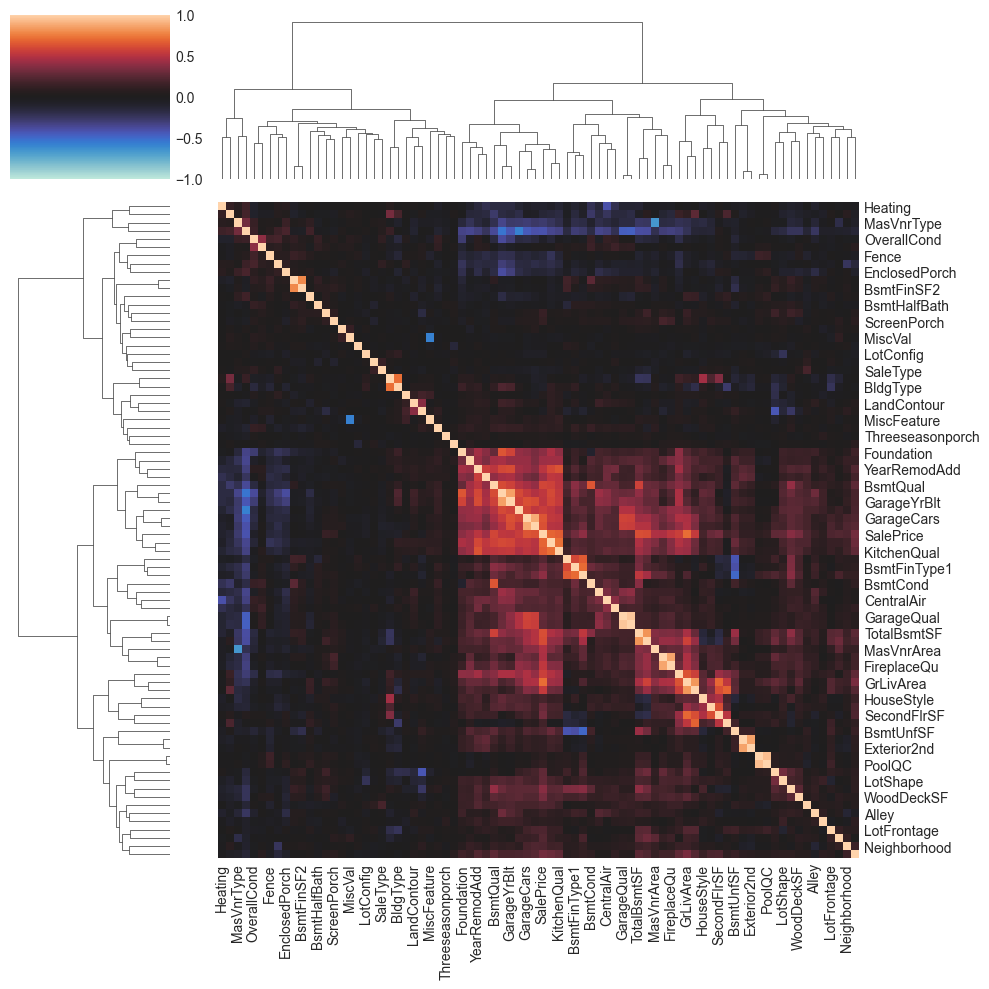

In [30]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    df = label_encode(df)
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)

Groups of highly correlated features often yield interesting loadings.

#### PCA Application - Indicate Outliers
Some models can benefit from having these outliers indicated, which is what this next transform will do.

You could also consider applying some sort of robust scaler from scikit-learn's sklearn.preprocessing module to the outlying values, especially those in GrLivArea. Here is a tutorial illustrating some of them. Another option could be to create a feature of "outlier scores" using one of scikit-learn's outlier detectors.

https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

https://scikit-learn.org/stable/modules/outlier_detection.html

In [27]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
    return X_new

### Target Encoding
Needing a separate holdout set to create a target encoding is rather wasteful of data. There is, however, a way you can use target encoding without having to use held-out encoding data. It's basically the same trick used in cross-validation:

1. Split the data into folds, each fold having two splits of the dataset.
2. Train the encoder on one split but transform the values of the other.
3. Repeat for all the splits.
This way, training and transformation always take place on independent sets of data, just like when you use a holdout set but without any data going to waste.

In the next hidden cell is a wrapper we can use with any target encoder:

In [28]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs #keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transfor the feature on the other
    # Interating over the splits in all folds gives a complete transformation.
    # We also now have one trained encoder on each fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train, in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(X.iloc[idx_encode, :], y.iloc[idx_encode],)
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)

        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + '_encoded' for name in X_encoded.columns]
        return X_encoded
    
    # TO transform the test data, average the encodings learning from each fold
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])

        X_encoded = reduce(lambda x, y: x.add(y, fill_value=0), X_encoded_list) / len(X_encoded_list)
        X_encoded.columns = [name + '_encoded' for name in X_encoded.columns]

        return X_encoded

Use it like:
- encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
- X_encoded = encoder.fit_transform(X, y, cols=["MSSubClass"]))


we can turn any of the encoders from the category_encoders library into a cross-fold encoder. The CatBoostEncoder would be worth trying. It's similar to MEstimateEncoder but uses some tricks to better prevent overfitting. Its smoothing parameter is called a instead of m.

### Create Final Feature Set
Now let's combine everything together. Putting the transformations into separate functions makes it easier to experiment with various combinations. we should experiment with our own ideas though! Modify any of these transformations or come up with some of our own to add to the pipeline.

In [87]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Lesson 2 - Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Lesson 3 - Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    #X = X.join(break_down(X))
    X = X.join(group_transforms(X))

    # Lesson 4 - Clustering
    X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    #X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    # Lesson 5 - PCA
    X = X.join(pca_inspired(X))
    #X = X.join(pca_components(X, pca_features))
    #X = X.join(indicate_outliers(X))

    X = label_encode(X)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Lesson 6 - Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


df_train, df_test = preprocessing_df(df, df_pretrain, df_pretest)

X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

score_dataset(X_train, y_train)

0.13953899355397326

### Step 4 - Hyperparameter Tuning
At this stage, we might like to do some hyperparameter tuning with XGBoost

In [88]:
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

xgb_params = dict(
    max_depth=6,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

0.12432832952762762

In [90]:
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params

[I 2023-08-10 23:27:35,665] A new study created in memory with name: no-name-cde6d93d-4654-4a75-a8f5-49a9a0ce9089
[I 2023-08-10 23:27:47,374] Trial 0 finished with value: 4.836072762383566 and parameters: {'max_depth': 2, 'learning_rate': 0.00025987736229172244, 'n_estimators': 3419, 'min_child_weight': 9, 'colsample_bytree': 0.5730884106258183, 'subsample': 0.23869064450843638, 'reg_alpha': 0.00047092327480332933, 'reg_lambda': 5.390076690240713}. Best is trial 0 with value: 4.836072762383566.
[I 2023-08-10 23:28:14,166] Trial 1 finished with value: 0.8886417891010656 and parameters: {'max_depth': 10, 'learning_rate': 0.0003812864439830842, 'n_estimators': 7223, 'min_child_weight': 10, 'colsample_bytree': 0.509669204060714, 'subsample': 0.2928926643514704, 'reg_alpha': 0.000647797904831411, 'reg_lambda': 12.966222488531816}. Best is trial 1 with value: 0.8886417891010656.
[I 2023-08-10 23:28:24,696] Trial 2 finished with value: 5.2890052563570515 and parameters: {'max_depth': 10, 'lea